# Cost Estimation For IRIDE Constellation


## Imports

In [44]:
import pandas as pd
pd.set_option('expand_frame_repr', False)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tabulate import tabulate
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# plt.style.use('_mpl-gallery')

## Costs

In [46]:
dtype_dict = {
    'Type': str,
    'Recurring Period (year)': int,
    'Date': int,
    'Activity Duration': int,
    'Amortization Duration': int,
    'Firm': str,
    'Description': str,
    'Cost (€ mil)': float,
    'Classification': str,
    'Origin': str,
    'Estimation method': str
}

df_costs_oth = pd.read_csv('costs-others2.csv', dtype=dtype_dict, thousands=',', decimal='.')

print(df_costs_oth)

                      Short Name  Recurring Period (year)  Date  Activity Duration  Amortization Duration        Firm                                        Description  Cost (€ mil)      Classification                                             Origin                                  Estimation method
0                      Financing                        0  2023                  0                      0         NaN                Initial budget invested in the firm      1,100.00           Financing  https://www.esa.int/Space_in_Member_States/Ita...                                             Copied
1               Satellite b1 RnD                        0  2023                  1                      5         Mix                                        B1 Fix Cost         53.67        Build Assets                                     Previous Table                                                  -
2       Satellite b1 Development                        6  2023                  1   

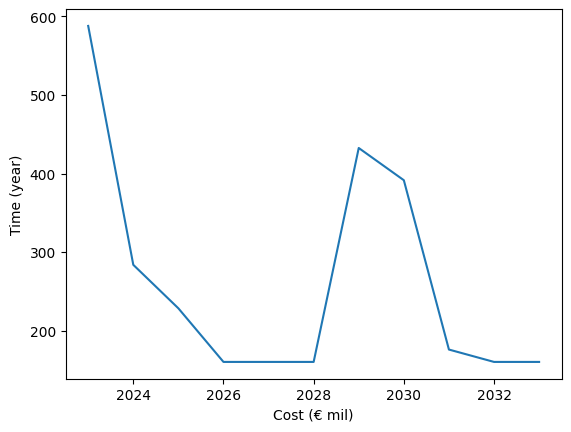

In [47]:
simulation_length = 11 # # of years
time = np.arange(
    np.min(df_costs_oth["Date"]),     # Begin of the simulation
    np.min(df_costs_oth["Date"]) + simulation_length # End of the simulation
    )
costs = np.zeros(simulation_length)
for index, row in df_costs_oth.iterrows():
    if row["Classification"] != "Financing":
        first_pos = row["Date"] - time[0]
        costs[first_pos] += row["Cost (€ mil)"]
        if row["Recurring Period (year)"] > 0:
            first_pos += row["Recurring Period (year)"]
            while first_pos < simulation_length:
                costs[first_pos] += row["Cost (€ mil)"]
                first_pos += row["Recurring Period (year)"]

plt.plot(time, costs)
plt.xlabel('Cost (€ mil)')
plt.ylabel('Time (year)')
plt.show()

## Market Demand Simulator

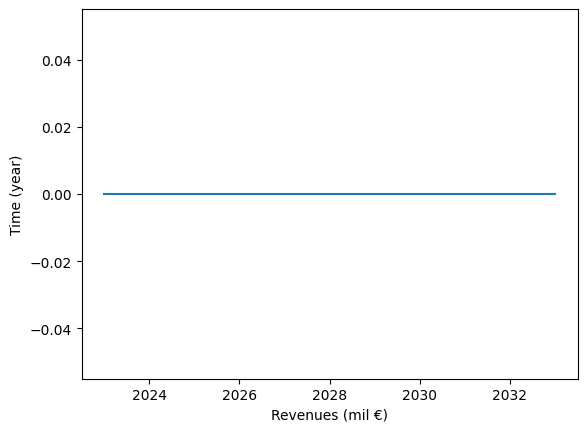

In [57]:
def market_demand_simulator(time:list, first_year_of_revenue:int, max_penetration:float=0):
    market_size_data_2023 = 100
    market_size_data_2033 = 195
    market_size_added_val_2023 = 415
    market_size_added_val_2033 = 760
    market_size_data_CAGR = (market_size_data_2033/market_size_data_2023)**(1/(2033-2023))-1
    market_size_added_val_CAGR = (market_size_added_val_2033/market_size_added_val_2023)**(1/(2033-2023))-1

    market_penetration = np.zeros(simulation_length)
    market_penetration[time == first_year_of_revenue] = 0.5 * max_penetration
    market_penetration[time >  first_year_of_revenue] = max_penetration

    revenues = np.zeros(simulation_length)
    for ii in range(0,simulation_length):
        revenues[ii] = ((market_size_data_2023 * (1 + market_size_data_CAGR) ** ii + 
            market_size_added_val_2023 * (1 + market_size_added_val_CAGR) ** ii) * 
            market_penetration[ii])
    return revenues

revenues = market_demand_simulator(time, 2026)
plt.plot(time, revenues)
plt.xlabel('Revenues (mil €)')
plt.ylabel('Time (year)')
plt.show()

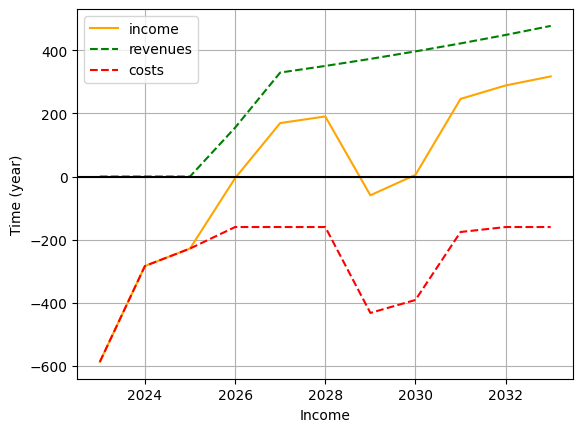

In [40]:
plt.plot(time, revenues - costs, color="orange")
plt.plot(time, revenues, "--", color="green")
plt.plot(time, -costs, "--", color="red")
plt.grid()
plt.xlabel('Income')
plt.ylabel('Time (year)')
plt.legend(["income", "revenues", "costs"])
plt.axhline(y=0, color='k')
plt.show()

## Financial Statements Simulator

In [41]:
pd.options.display.float_format = '{:,.2f}'.format
class FinancialStatementSimulator():
    def __init__(self, first_year:int=2023, duration:int=11, wacc:float=1):
        self.first_year = first_year
        self.duration = duration
        self.wacc = wacc
        self.years = [first_year + i for i in range(duration)]
        self.delta_balance_sheet = pd.DataFrame(0, index=self.years, columns=[
            'Current Assets',
            'Non-current Assets',
            'Total Assets',
            'Liability',
            'Equity',
            'Total Equity n Liability'
        ]).astype('float64')
        self.balance_sheet = pd.DataFrame(0, index=self.years, columns=[
            'Current Assets',
            'Non-current Assets',
            'Total Assets',
            'Liability',
            'Equity',
            'Total Equity n Liability'
        ]).astype('float64')
        self.income_statement = pd.DataFrame(0, index=self.years, columns=[
            'Revenues',
            'Cost of Revenues',
            'Gross Profit',
            'Operating Expenses',
            'EBITDA',
            'Depreciation & Amortizations',
            'EBIT',
            'Interest Expenses',
            'Tax Expenses',
            'Tax Ratio',
            'Net Income'
        ]).astype('float64')
        self.cash_flow_statement = pd.DataFrame(0, index=self.years, columns=[
            'Operating CF',
            'Investing CF',
            'Financing CF',
            'Net Change in Cash'
        ]).astype('float64')
        
    def _get_year_index(self, year:int):
        if year < self.first_year or year >= self.first_year + self.duration:
            raise ValueError("Year out of bounds.")
        return year
    
    def _update_derivate_numbers(self):
        # Update income statement derived numbers
        self.income_statement['Gross Profit'] = self.income_statement['Revenues'] + self.income_statement['Cost of Revenues']
        self.income_statement['EBITDA'] = self.income_statement['Gross Profit'] + self.income_statement['Operating Expenses']
        self.income_statement['EBIT'] = self.income_statement['EBITDA'] + self.income_statement['Depreciation & Amortizations']
        self.income_statement['Tax Expenses'] = (self.income_statement['EBIT'] + self.income_statement['Interest Expenses']) * (-self.income_statement['Tax Ratio'])
        self.income_statement['Net Income'] = (self.income_statement['EBIT'] + self.income_statement['Interest Expenses']) * (1 - self.income_statement['Tax Ratio'])
        # Update balance sheet derived numbers
        self.balance_sheet = self.delta_balance_sheet.cumsum()
        self.balance_sheet['Total Assets'] = self.balance_sheet['Current Assets'] + self.balance_sheet['Non-current Assets']
        self.balance_sheet['Total Equity n Liability'] = self.balance_sheet['Equity'] + self.balance_sheet['Liability']
        # Update cash flow statements derived numbers
        self.cash_flow_statement['Net Change in Cash'] = self.cash_flow_statement['Operating CF'] + self.cash_flow_statement['Investing CF'] + self.cash_flow_statement['Financing CF']

    def finance(self, year:int, amount:float, debt:bool=False):
        yy = self._get_year_index(year)
        self.cash_flow_statement.at[yy, 'Financing CF'] += amount
        self.delta_balance_sheet.at[yy, 'Current Assets'] += amount
        if debt:
            self.delta_balance_sheet.at[yy, 'Liability'] += amount
        else:
            self.delta_balance_sheet.at[yy, 'Equity'] += amount
        self._update_derivate_numbers()
    
    def build_asset(self, year:int, amount:float, amortization_duration:int, recurring_step:int):
        yy = self._get_year_index(year)
        delta = amount / amortization_duration
        jj = yy
        while jj < self.first_year + self.duration:
            self.delta_balance_sheet.at[jj, 'Current Assets'] -= amount
            self.delta_balance_sheet.at[jj, 'Non-current Assets'] += amount
            for ii in range(1, amortization_duration + 1):
                if jj + ii >= self.first_year + self.duration:
                    break
                tax = self.income_statement.at[jj + ii, 'Tax Ratio']
                self.delta_balance_sheet.at[jj + ii, 'Equity'] -= delta * (1 - tax)
                self.delta_balance_sheet.at[jj + ii, 'Non-current Assets'] -= delta * (1 - tax)
                self.income_statement.at[jj + ii, 'Depreciation & Amortizations'] -= delta
                self.cash_flow_statement.at[jj + ii, 'Operating CF'] += delta * tax
            jj += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()

    
    def pay_operating_expenses(self, year:int, amount:float, recurring_step:int):
        yy = self._get_year_index(year)
        while yy < self.first_year + self.duration:
            tax = self.income_statement.at[yy, 'Tax Ratio']
            self.delta_balance_sheet.at[yy, 'Current Assets'] -= amount * (1 - tax)
            self.delta_balance_sheet.at[yy, 'Equity'] -= amount * (1 - tax)
            self.cash_flow_statement.at[yy, 'Operating CF'] -= amount * (1 - tax)
            self.income_statement.at[yy, 'Operating Expenses'] -= amount
            yy += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()
    
    def get_revenues(self, year:int, amount:float, recurring_step:int):
        yy = self._get_year_index(year)
        while yy < self.first_year + self.duration:
            tax = self.income_statement.at[yy, 'Tax Ratio']
            self.delta_balance_sheet.at[yy, 'Current Assets'] += amount * (1 - tax)
            self.delta_balance_sheet.at[yy, 'Equity'] += amount * (1 - tax)
            self.cash_flow_statement.at[yy, 'Operating CF'] += amount * (1 - tax)
            self.income_statement.at[yy, 'Revenues'] += amount
            yy += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()
    
    def set_tax_ratios(self, tax_ratios:float|list):
        if isinstance(tax_ratios, list):
            if len(tax_ratios) != self.duration:
                raise ValueError("The length of the tax_ratios does not match the duration")
        self.income_statement['Tax Ratio'] = tax_ratios
    
    def net_present_value(self):
        net_change_in_cash = self.cash_flow_statement['Operating CF'].values + self.cash_flow_statement['Investing CF'].values - self.cash_flow_statement['Financing CF'].values
        years = np.arange(0, len(net_change_in_cash))
        discounted_cash = net_change_in_cash / (1 + self.wacc) ** years
        npv = np.sum(discounted_cash)
        return npv
    
    def print_results(self):
        print("Balance Sheet:")
        print(self.balance_sheet.T)
        print("\nIncome Statement:")
        print(self.income_statement.T)
        print("\nCash Flow Statement:")
        print(self.cash_flow_statement.T)

# Usage
fss = FinancialStatementSimulator(first_year=2023, duration=simulation_length, wacc=0.0333)
fss.set_tax_ratios(.24)
fss.finance(year=2023, amount=1100)
fss.build_asset(year=2023, amount=53.67,  amortization_duration=5, recurring_step=0)
fss.build_asset(year=2023, amount=127.00, amortization_duration=5, recurring_step=0)
fss.build_asset(year=2023, amount=272.33, amortization_duration=5, recurring_step=6)
fss.build_asset(year=2024, amount=216.00, amortization_duration=5, recurring_step=6)

fss.pay_operating_expenses(year=2025, amount=160.15, recurring_step=1)
fss.pay_operating_expenses(year=2024, amount=212.87, recurring_step=6)
fss.pay_operating_expenses(year=2025, amount=219.13, recurring_step=6)
for ii in range(0, simulation_length):
    fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)

print("NPV = ", fss.net_present_value())

fss.print_results()


NPV =  -577.8950631341239
Balance Sheet:
                             2023   2024   2025   2026   2027   2028   2029   2030   2031   2032   2033
Current Assets             647.00 269.22 -19.03 -22.99 105.81 250.57 139.98 -58.01 -25.54 193.90 435.09
Non-current Assets         453.00 600.14 498.46 396.77 295.08 193.39 432.89 607.50 533.27 459.04 384.82
Total Assets             1,100.00 869.36 479.42 373.78 400.89 443.96 572.87 549.49 507.73 652.95 819.91
Liability                    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Equity                   1,100.00 869.36 479.42 373.78 400.89 443.96 572.87 549.49 507.73 652.95 819.91
Total Equity n Liability 1,100.00 869.36 479.42 373.78 400.89 443.96 572.87 549.49 507.73 652.95 819.91

Income Statement:
                              2023    2024    2025    2026    2027    2028    2029    2030    2031    2032    2033
Revenues                      0.00    0.00    0.00  154.94  329.63  350.62  372.96  396.72  422.0

## Scheduler

In [56]:
dtype_dict = {
    'Type': str,
    'Recurring Period (year)': int,
    'Date': int,
    'Activity Duration': int,
    'Amortization Duration': int,
    'Firm': str,
    'Description': str,
    'Cost (€ mil)': float,
    'Classification': str,
    'Origin': str,
    'Estimation method': str
}

activities = pd.read_csv('costs-others2.csv', dtype=dtype_dict, thousands=',', decimal='.')

# Define the project parameters
project_begin = 2023
satellite_lifespan = 5
satellite_launch_delay = 0
simulation_length = 11
tax_rate = .24

# Define activities in a structured manner
# activities = pd.DataFrame([
#     {"name": "Finance",                    "type": "finance",                "begin": project_begin, "amount": 1100.00, "duration": 0, "amortization duration": 0, "recurring": 0},
#     {"name": "Satellite b1 RnD",           "type": "build_asset",            "begin": project_begin, "amount":   53.67, "duration": 1, "amortization duration": 5, "recurring": 0},
#     {"name": "Infrastructure Development", "type": "build_asset",            "begin": project_begin, "amount":  127.00, "duration": 1, "amortization duration": 5, "recurring": 0},
#     {"name": "Satellite b1 Development",   "type": "build_asset",            "begin": project_begin, "amount":  272.33, "duration": 1, "amortization duration": 5, "recurring": satellite_lifespan + 1},
#     {"name": "Satellite b2 Development",   "type": "build_asset",            "begin": None,          "amount":  216.00, "duration": 1, "amortization duration": 5, "recurring": satellite_lifespan + 1},
#     {"name": "Operation Infrastructure",   "type": "pay_operating_expenses", "begin": None,          "amount":  160.15, "duration": 1, "amortization duration": 0, "recurring": 1},
#     {"name": "Satellite b1 Launch",        "type": "pay_operating_expenses", "begin": None,          "amount":  212.87, "duration": 1, "amortization duration": 0, "recurring": satellite_lifespan + 1},
#     {"name": "Satellite b2 Launch",        "type": "pay_operating_expenses", "begin": None,          "amount":  219.13, "duration": 1, "amortization duration": 0, "recurring": satellite_lifespan + 1}
# ])
activities.set_index("Short Name", inplace=True)
# name -> Short Nane
# begin    -> Date
# amount   -> Cost (€ mil)
# duration -> Activity Duration
# amortization duration -> Amortization Duration
# recurring -> Recurring Period (year)
# type -> Classification

# Calculate the begin times for dependent activities
activities.at["Satellite b2 Development", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"]
activities.at["Satellite b1 Launch", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Satellite b2 Launch", "Date"] = activities.at["Satellite b2 Development", "Date"] + activities.at["Satellite b2 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Operation Infrastructure 1", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 2", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 3", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 4", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 6", "Date"] = activities.at["Operation Infrastructure 5", "Date"] + activities.at["Operation Infrastructure 5", "Activity Duration"]
activities.at["Operation Infrastructure 7", "Date"] = activities.at["Operation Infrastructure 6", "Date"] + activities.at["Operation Infrastructure 6", "Activity Duration"]
revenues = market_demand_simulator(time, activities.at["Satellite b2 Launch", "Date"] + activities.at["Satellite b2 Launch", "Activity Duration"])

# Initialize the FinancialPeriod
fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=0.0333)
fss.set_tax_ratios(tax_rate)

# Process each activity in the DataFrame
for name, activity in activities.iterrows():
    if activity["Classification"] == "Financing":
        # pass
        fss.finance(year=activity["Date"], amount=activity["Cost (€ mil)"])
    elif activity["Classification"] == "Build Assets":
        # pass
        fss.build_asset(year=activity["Date"], amount=activity["Cost (€ mil)"], amortization_duration=activity["Amortization Duration"], recurring_step=activity["Recurring Period (year)"])
    elif activity["Classification"] == "Operation Expenses":
        fss.pay_operating_expenses(year=activity["Date"], amount=activity["Cost (€ mil)"], recurring_step=activity["Recurring Period (year)"])

# Simulate the revenues
for ii in range(simulation_length):
    fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)

# Print the results
print('Activities:')
print(activities)
print('\n')
fss.print_results()


Activities:
                              Recurring Period (year)  Date  Activity Duration  Amortization Duration        Firm                                        Description  Cost (€ mil)      Classification                                             Origin                                  Estimation method
Short Name                                                                                                                                                                                                                                                                                                  
Financing                                           0  2023                  0                      0         NaN                Initial budget invested in the firm      1,100.00           Financing  https://www.esa.int/Space_in_Member_States/Ita...                                             Copied
Satellite b1 RnD                                    0  2023                  1       

# NPV Simulation

In [69]:
# Inport activities
dtype_dict = {
    'Type': str,
    'Recurring Period (year)': int,
    'Date': int,
    'Activity Duration': int,
    'Amortization Duration': int,
    'Firm': str,
    'Description': str,
    'Cost (€ mil)': float,
    'Classification': str,
    'Origin': str,
    'Estimation method': str
}
activities = pd.read_csv('costs-others2.csv', dtype=dtype_dict, thousands=',', decimal='.')
activities.set_index("Short Name", inplace=True)
# Set initial values
project_begin = 2023
satellite_lifespan = 5
satellite_launch_delay = 0
simulation_length = 11
tax_rate = .24
# Set the schedule
activities.at["Satellite b2 Development", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"]
activities.at["Satellite b1 Launch", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Satellite b2 Launch", "Date"] = activities.at["Satellite b2 Development", "Date"] + activities.at["Satellite b2 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Operation Infrastructure 1", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 2", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 3", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 4", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 6", "Date"] = activities.at["Operation Infrastructure 5", "Date"] + activities.at["Operation Infrastructure 5", "Activity Duration"]
activities.at["Operation Infrastructure 7", "Date"] = activities.at["Operation Infrastructure 6", "Date"] + activities.at["Operation Infrastructure 6", "Activity Duration"]

def npv_simulation(wacc, max_penetration):
    # Initialize the FinancialPeriod
    fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=wacc)
    fss.set_tax_ratios(tax_rate)
    # Process each activity in the DataFrame
    for name, activity in activities.iterrows():
        if activity["Classification"] == "Financing":
            # pass
            fss.finance(year=activity["Date"], amount=activity["Cost (€ mil)"])
        elif activity["Classification"] == "Build Assets":
            # pass
            fss.build_asset(year=activity["Date"], amount=activity["Cost (€ mil)"], amortization_duration=activity["Amortization Duration"], recurring_step=activity["Recurring Period (year)"])
        elif activity["Classification"] == "Operation Expenses":
            fss.pay_operating_expenses(year=activity["Date"], amount=activity["Cost (€ mil)"], recurring_step=activity["Recurring Period (year)"])
    # Setting revenues
    revenues = market_demand_simulator(time=time, first_year_of_revenue=activities.at["Satellite b2 Launch", "Date"] + activities.at["Satellite b2 Launch", "Activity Duration"], max_penetration=max_penetration)
    # Simulate the revenues
    for ii in range(simulation_length):
        fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)
    return fss.net_present_value()

penetration = np.arange(0, 1.01, 0.01)
npv_wacc_0 = np.zeros_like(penetration)         # 0
npv_wacc_ses = np.zeros_like(penetration)       # 0.0432
npv_wacc_planetlab = np.zeros_like(penetration) # 0.0767
npv_wacc_05 = np.zeros_like(penetration) # 0.0767

for idx, pp in enumerate(penetration):
    npv_wacc_0[idx] = npv_simulation(wacc=0, max_penetration=pp)
    npv_wacc_ses[idx] = npv_simulation(wacc=0.0432, max_penetration=pp)
    npv_wacc_planetlab[idx] = npv_simulation(wacc=0.0767, max_penetration=pp)
    npv_wacc_05[idx] = npv_simulation(wacc=0.0767/2, max_penetration=pp)


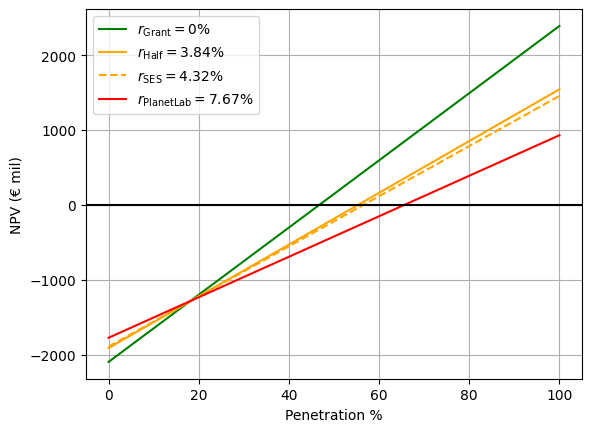

<Figure size 640x480 with 0 Axes>

In [85]:
wacc_values = [0, 0.0384, 0.0432, 0.0767]  # WACC values in decimal

# Define colors and line styles
colors = {
    0: 'green',
    0.0384: 'orange',
    0.0432: 'orange',
    0.0767: 'red'
}

linestyles = {
    0: '-',
    0.0384: '-',
    0.0432: '--',
    0.0767: '-'
}

# Plot each line with the corresponding color and style
plt.plot(penetration * 100, npv_wacc_0, color=colors[0], linestyle=linestyles[0], label=r"$r_{\text{Grant}} = 0\%$")
plt.plot(penetration * 100, npv_wacc_05, color=colors[0.0384], linestyle=linestyles[0.0384], label=r"$r_{\text{Half}} = 3.84\%$")
plt.plot(penetration * 100, npv_wacc_ses, color=colors[0.0432], linestyle=linestyles[0.0432], label=r"$r_{\text{SES}} = 4.32\%$")
plt.plot(penetration * 100, npv_wacc_planetlab, color=colors[0.0767], linestyle=linestyles[0.0767], label=r"$r_{\text{PlanetLab}} = 7.67\%$")

# Configure plot
plt.xlabel('Penetration %')
plt.ylabel('NPV (€ mil)')
plt.grid()
plt.legend()
plt.axhline(y=0, color='k')

# Show plot
plt.show()
plt.savefig('plot-NPVs.pdf', format='pdf')


In [88]:
def find_zero_crossings(x, y):
    indices = np.where(np.diff(np.sign(y)))[0]
    zero_crossings = []
    for i in indices:
        x0 = x[i] + (x[i+1] - x[i]) * (0 - y[i]) / (y[i+1] - y[i])
        zero_crossings.append(x0)
    return zero_crossings

crossings_ses = find_zero_crossings(penetration, npv_wacc_ses)
crossings_planetlab = find_zero_crossings(penetration, npv_wacc_planetlab)
crossings_05 = find_zero_crossings(penetration, npv_wacc_05)
crossings_0 = find_zero_crossings(penetration, npv_wacc_0)

print("y=0 crossings_ses: ", crossings_ses[0])
print("y=0 crossings_planetlab: ", crossings_planetlab[0])
print("y=0 crossings_05: ", crossings_05[0])
print("y=0 crossings_0: ", crossings_0[0])

y=0 crossings_ses:  0.5654931794442312
y=0 crossings_planetlab:  0.6562459779285482
y=0 crossings_05:  0.553460794465732
y=0 crossings_0:  0.46748522420622585


## Monte Carlo Simulations

In [43]:
# elements = [1.1, 2.2, 3.3]
# probabilities = [0.2, 0.5, 0.3]
# np.random.choice(a=elements, size=1, p=probabilities)

def simulation():
    project_begin = 2023
    satellite_lifespan = 5
    satellite_launch_delay = 0
    simulation_length = 11
    tax_rate = .24

    # Define activities in a structured manner
    activities = pd.DataFrame([
        {"name": "Finance",                    "type": "finance",                "begin": project_begin, "amount": 1100.00, "duration": 0, "amortization duration": 0, "recurring": 0},
        {"name": "Satellite b1 RnD",           "type": "build_asset",            "begin": project_begin, "amount":   53.67, "duration": 1, "amortization duration": 5, "recurring": 0},
        {"name": "Infrastructure Development", "type": "build_asset",            "begin": project_begin, "amount":  127.00, "duration": 1, "amortization duration": 5, "recurring": 0},
        {"name": "Satellite b1 Development",   "type": "build_asset",            "begin": project_begin, "amount":  272.33, "duration": 1, "amortization duration": 5, "recurring": satellite_lifespan + 1},
        {"name": "Satellite b2 Development",   "type": "build_asset",            "begin": None,          "amount":  216.00, "duration": 1, "amortization duration": 5, "recurring": satellite_lifespan + 1},
        {"name": "Operation Infrastructure",   "type": "pay_operating_expenses", "begin": None,          "amount":  160.15, "duration": 1, "amortization duration": 0, "recurring": 1},
        {"name": "Satellite b1 Launch",        "type": "pay_operating_expenses", "begin": None,          "amount":  212.87, "duration": 1, "amortization duration": 0, "recurring": satellite_lifespan + 1},
        {"name": "Satellite b2 Launch",        "type": "pay_operating_expenses", "begin": None,          "amount":  219.13, "duration": 1, "amortization duration": 0, "recurring": satellite_lifespan + 1}
    ])
    activities.set_index("name", inplace=True)

    # Calculate the begin times for dependent activities
    activities.at["Satellite b2 Development", "begin"] = activities.at["Satellite b1 Development", "begin"] + activities.at["Satellite b1 Development", "duration"]
    activities.at["Satellite b1 Launch", "begin"] = activities.at["Satellite b1 Development", "begin"] + activities.at["Satellite b1 Development", "duration"] + satellite_launch_delay
    activities.at["Satellite b2 Launch", "begin"] = activities.at["Satellite b2 Development", "begin"] + activities.at["Satellite b2 Development", "duration"] + satellite_launch_delay
    activities.at["Operation Infrastructure", "begin"] = activities.at["Satellite b1 Launch", "begin"] + activities.at["Satellite b1 Launch", "duration"]
    revenues = market_demand_simulator(time, activities.at["Satellite b2 Launch", "begin"] + activities.at["Satellite b2 Launch", "duration"])

    # Initialize the FinancialPeriod
    fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=0.0333)
    fss.set_tax_ratios(tax_rate)

    # Process each activity in the DataFrame
    for name, activity in activities.iterrows():
        if activity["type"] == "finance":
            fss.finance(year=activity["begin"], amount=activity["amount"])
        elif activity["type"] == "build_asset":
            fss.build_asset(year=activity["begin"], amount=activity["amount"], amortization_duration=activity["amortization duration"], recurring_step=activity["recurring"])
        elif activity["type"] == "pay_operating_expenses":
            fss.pay_operating_expenses(year=activity["begin"], amount=activity["amount"], recurring_step=activity["recurring"])

    # Simulate the revenues
    for ii in range(simulation_length):
        fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)
    return fss.net_present_value()

for ii in range(10):
    print(simulation())

-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
-577.8950631341239
